# Data Quality & Utility Evaluation

In [9]:
import json
from evaluation import UtilityEval
from data.data_utils import get_sequences_from_file
from metrics import *

SOURCE_DATA_FIGURES = 'figures/source_data'
UTILITY_FIGURES = 'figures/generated_data/utility_eval'

data_size = 'medium'
vars_num = 10000

In [10]:
TRAIN_DATA = f'data/sources/json/{data_size}/train_gts_with_pop.json' 
HOLDOUT_DATA = f'data/sources/json/{data_size}/holdout_gts_with_pop.json'
VAL_DATA = f'data/sources/json/{data_size}/val_gts_with_pop.json'

In [11]:
import matplotlib.pyplot as plt
import tqdm

def plot_utility_statistics(utility_eval, model_name, save_path = None):
    key_to_plot_dict = {'mut_validity' : {'title': f'{model_name} Mutation Validity', 
                                        'xlabel': 'Ratio Valid/All mutations', 
                                        'ylabel': 'Frequency'},
                        'mut_quality' : {'title': f'{model_name} Mutation Quality', 
                                        'xlabel': 'Ratio Positionally Valid/All mutations', 
                                        'ylabel': 'Frequency'},
                        'mut_memorization' : {'title': f'{model_name} Mutation Memorization', 
                                            'xlabel': 'Number Memorized Mutations', 
                                            'ylabel': 'Frequency'},
                        'mut_novelty' : {'title': f'{model_name} Mutation Novelty', 
                                        'xlabel': 'Number Novel Mutations', 
                                        'ylabel': 'Frequency'},
                        'mut_uniqueness' : {'title': f'{model_name} Mutation Uniqueness', 
                                            'xlabel': 'Number Unique Mutations amongst samples', 
                                            'ylabel': 'Frequency'},
                        'mut_repetition' : {'title': f'{model_name} Mutation Repetition', 
                                            'xlabel': 'Repetition', 
                                            'ylabel': 'Number Repeating Mutations amongst samples'},
                        # 'mut_distribution' : {'title': 'Mutation Distribution', 
                        #                       'xlabel': 'Distribution', 
                        #                       'ylabel': 'Frequency'},
                        'mut_statistics' : {'title': f'{model_name} Mutation Statistics', 
                                            'xlabel': 'Statistic', 
                                            'ylabel': 'Frequency'},
                        'vcf_quality' : {'title': f'{model_name} VCF Quality', 
                                        'xlabel': 'Quality', 
                                        'ylabel': 'Frequency'}}

    plot_together = [k for k in ['mut_validity', 'mut_quality', 
                                'mut_memorization', 'mut_novelty',
                                'mut_uniqueness', 'mut_repetition'] if utility_eval.get(k) is not None]
    print_log = tqdm.tqdm(utility_eval.items())
    hist_values = {}
    for i, (key, value) in enumerate(print_log):
        if value is not None:
            print_log.set_description(f"Plotting {key}...")
            if key != 'mut_distribution':
                if key == 'vcf_quality':
                    fig, ax = plt.subplots(figsize=(20, 6))
                elif key not in ['mut_validity', 'mut_quality', 'mut_memorization', 'mut_novelty', 'mut_uniqueness', 'mut_repetition']:
                    fig, ax = plt.subplots(figsize=(10, 6))
                if isinstance(value, dict):
                    # ax2 = ax.twinx()
                    if isinstance(value, dict):
                        ax2 = ax.twinx()
                        for sub_key, sub_value in value.items():
                            if sub_key in 'FILTER':
                                for filter_key, filter_value in sub_value.items():
                                    ax2.bar(filter_key, filter_value, alpha=0.7, color='cornflowerblue')
                            elif sub_key == 'genotypes':
                                for gt_key, gt_value in sub_value.items():
                                    gt_dict = {'homozygous_ref':'homo ref', 
                                               'heterozygous_ref':'hetero ref', 
                                               'homozygous_alt':'homo alt'}
                                    ax2.bar(gt_dict[gt_key], gt_value, alpha=0.7, color='orchid')
                                    ax2.set_ylabel('Genotype Frequency', color='orchid')
                            else:
                                if sub_key in ['call_rate', 'AF','aaf']:
                                    ax2.bar(sub_key, sub_value, alpha=0.7, color='cornflowerblue')
                                    ax2.set_ylabel('Allele Frequency', color='cornflowerblue')
                                    ax2.tick_params(axis='y', labelcolor='cornflowerblue')
                                else:
                                    ax.bar(sub_key, sub_value, alpha=0.7, color='blue')
                    else:
                        ax.bar(value.keys(), value.values(), alpha=0.7, color='blue')
                else:
                    hist_values[key] = value
                    # ax.hist(value, bins=30, alpha=0.7, color='blue')
                    
                if key not in ['mut_validity', 'mut_quality', 'mut_memorization', 'mut_novelty', 'mut_uniqueness', 'mut_repetition']:
                    ax.set_title(key_to_plot_dict[key]['title'])
                    ax.set_xlabel(key_to_plot_dict[key]['xlabel'])
                    ax.set_ylabel(key_to_plot_dict[key]['ylabel'])
                    ax.grid(axis='y', alpha=0.75)
                    if save_path is not None:
                        plt.savefig(f'{save_path}_{model_name.replace(" ", "")}_{key}.pdf', format='pdf')
                    plt.show()
                else:
                    if len(hist_values) == len(plot_together):
                        from metrics import plot_metrics_by_model
                        plot_metrics_by_model([[v] for v in hist_values.values()],
                                                labels=[[k] for k in hist_values.keys()],
                                                title=f'{model_name} Mutations Basic Utility Metrics',
                                                xlabel='Metric',
                                                # x_ticks=list(hist_values.keys()),
                                                ylabel='Quality Score',
                                                cmap='tab20b',
                                                legend_title='Metric',
                                                bbox_to_anchor=(0.5, 0.5),
                                                save_path=f'{save_path}_{model_name.replace(" ", "")}_quality')
                        # for hist_key, hist_value in hist_values.items():
                        #     ax.hist(hist_value, bins=30, alpha=0.7, label=hist_key)
                        # ax.legend()
                        # ax.set_title(key_to_plot_dict[key]['title'])
                        # ax.set_xlabel(key_to_plot_dict[key]['xlabel'])
                        # ax.set_ylabel(key_to_plot_dict[key]['ylabel'])
                        # ax.grid(axis='y', alpha=0.75)
                        # if save_path is not None:
                        #     plt.savefig(f'{save_path}_{model_name.replace(" ", "")}_{key}.pdf', format='pdf')
                        # plt.show()
            else:
                from metrics import plot_variant_distribution
                plot_variant_distribution(value, title=f'{model_name} Variant Distribution',
                                          save_path=f'{save_path}_{model_name.replace(" ", "")}_{key}',
                                          colors='cornflowerblue')

# 0. Original 1000GP Data

In [12]:
training_gts = get_sequences_from_file(TRAIN_DATA)
training_gts = [gt['genotypes'] for gt in training_gts]
train_valid_sequences, train_valid_sequences_ratio, all_train_sequences = get_valid_sequences(training_gts, has_sample_names=True, sample_wise=True)

In [ ]:
eval_metrics = ['mut_validity', 'mut_quality', 'mut_distribution', 'mut_statistics', 'vcf_quality']
original_utility_eval = UtilityEval(None, 
                    model_name = 'Original Data',
                    ref_genomes = TRAIN_DATA, 
                    sample_wise=False,
                    vcf_file=f'/Volumes/asia_2T/genomics/reference/1000GP/corpus/{data_size}/filtered_{vars_num}snps.vcf.gz')
original_utility_eval.evaluate_model_utility(training_gts, metrics=eval_metrics, verbose=False)

Getting valid mutations for analysis...done!


Evaluating Original Data utility: 100%|██████████| 4/4 [01:03<00:00, 15.85s/it, mut_statistics evaluation...done!]  


In [28]:
original_utility_eval['vcf_quality']

{'FILTER': {'PASS': 1.0},
 'call_rate': 1.0,
 'AC': 176.69936353425683,
 'AF': 0.03528341831851144,
 'AN': 5008.0,
 'NS': 2504.0,
 'aaf': 0.03573814615771381}

In [ ]:
original_utility_eval.model_utility['mut_statistics']

{'deletions': 0.02789358745284892,
 'insertions': 0.01528687710939051,
 'substitutions': 0.958109986102839,
 'biallelic': 0.9918602342664284,
 'multiallelic': 0.00684931506849315}

In [130]:
with open('data/sources/1000GP/utility_eval.json', 'w+') as f:
    json.dump(original_utility_eval.model_utility, f)

Plotting mut_quality...:   0%|          | 0/6 [00:00<?, ?it/s] 

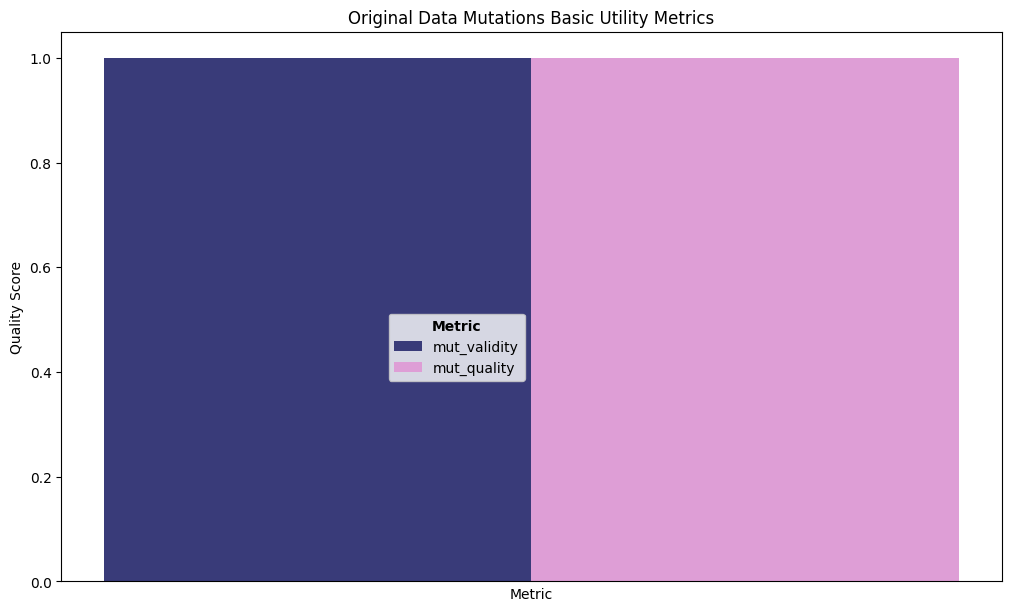

Plotting mut_quality...: 100%|██████████| 6/6 [00:00<00:00, 24.93it/s]


In [382]:
plot_test = {k:v for k, v in original_utility_eval.items() if k in ['mut_validity', 'mut_quality', 'mut_memorization',
                                                                           'mut_novelty', 'mut_uniqueness', 'mut_repetition']}
plot_utility_statistics(plot_test, 
                        model_name = 'Original Data')

Plotting mut_quality...:   0%|          | 0/9 [00:00<?, ?it/s] 

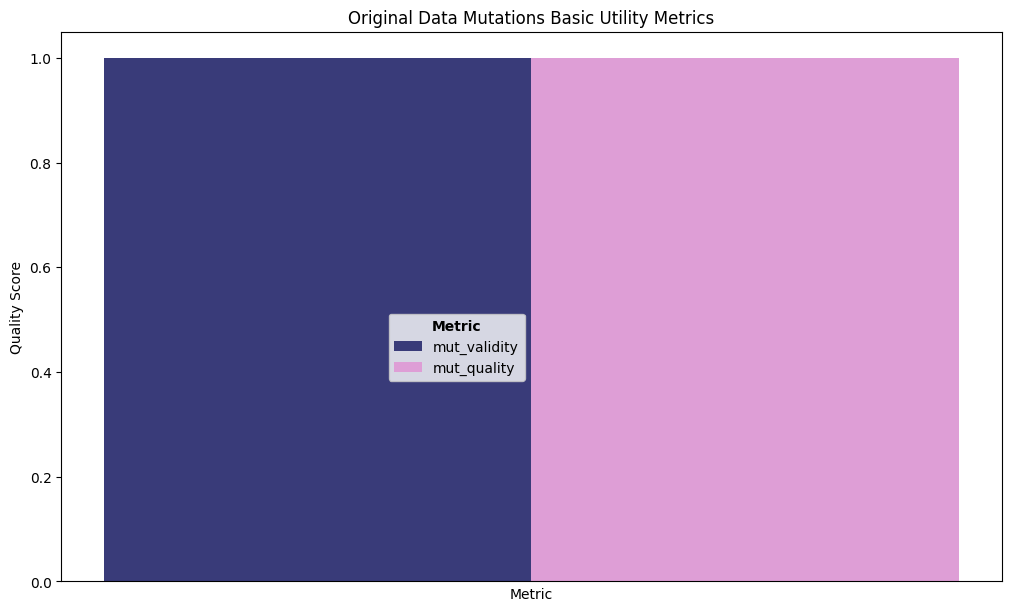

Plotting mut_distribution...:  22%|██▏       | 2/9 [00:00<00:00,  9.45it/s]

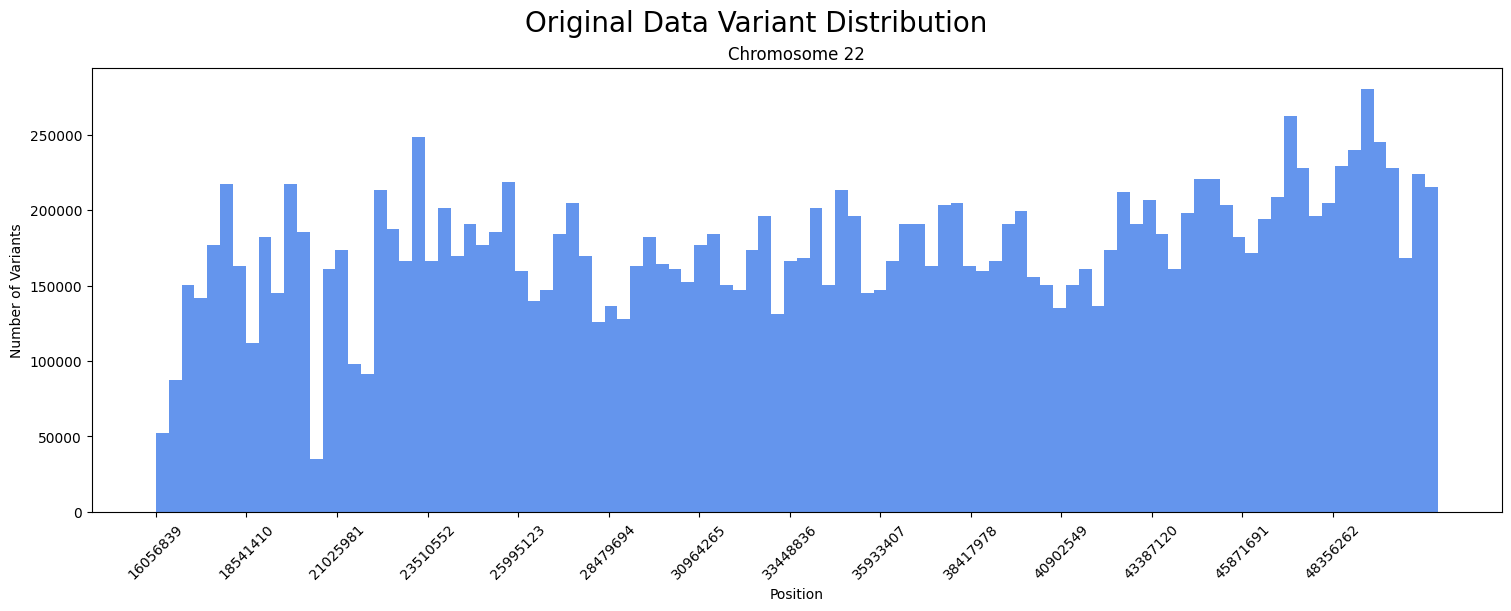

Plotting mut_statistics...:  78%|███████▊  | 7/9 [00:03<00:00,  2.10it/s]  

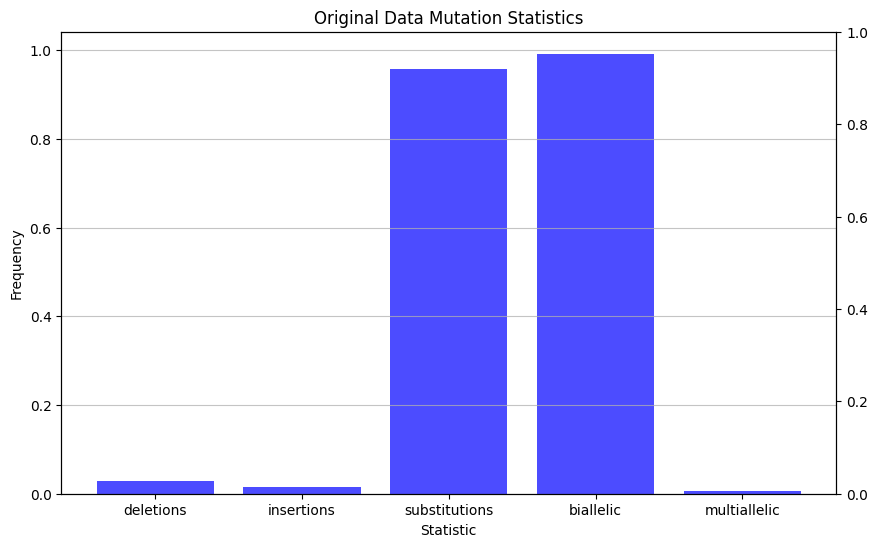

Plotting vcf_quality...:  89%|████████▉ | 8/9 [00:03<00:00,  2.30it/s]   

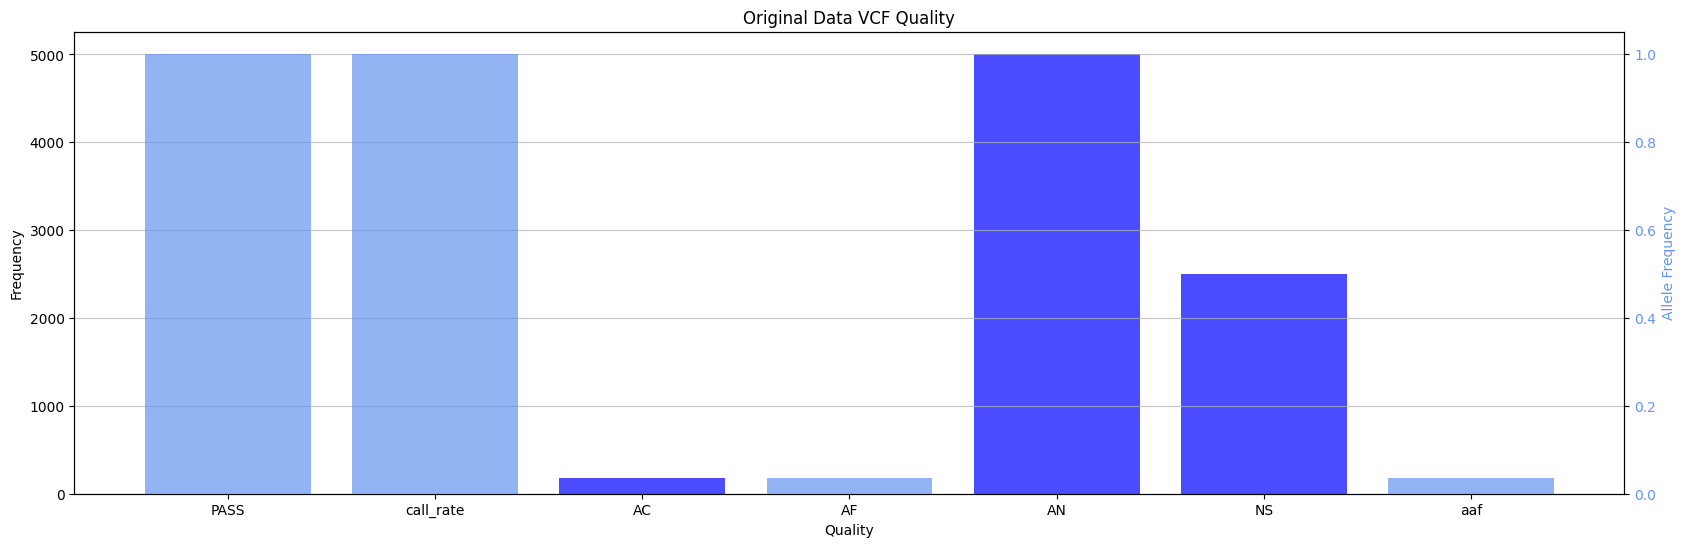

Plotting vcf_quality...: 100%|██████████| 9/9 [00:03<00:00,  2.48it/s]


In [378]:
plot_utility_statistics(original_utility_eval, 
                        model_name = 'Original Data',
                        save_path=f'{SOURCE_DATA_FIGURES}/utility')

___

# 1. Random VCF Generator

Getting valid mutations for analysis...done!


Evaluating Random Generator utility: 100%|██████████| 7/7 [00:28<00:00,  4.02s/it, vcf_quality evaluation...done!]     



Utility Evaluation for Random Generator:


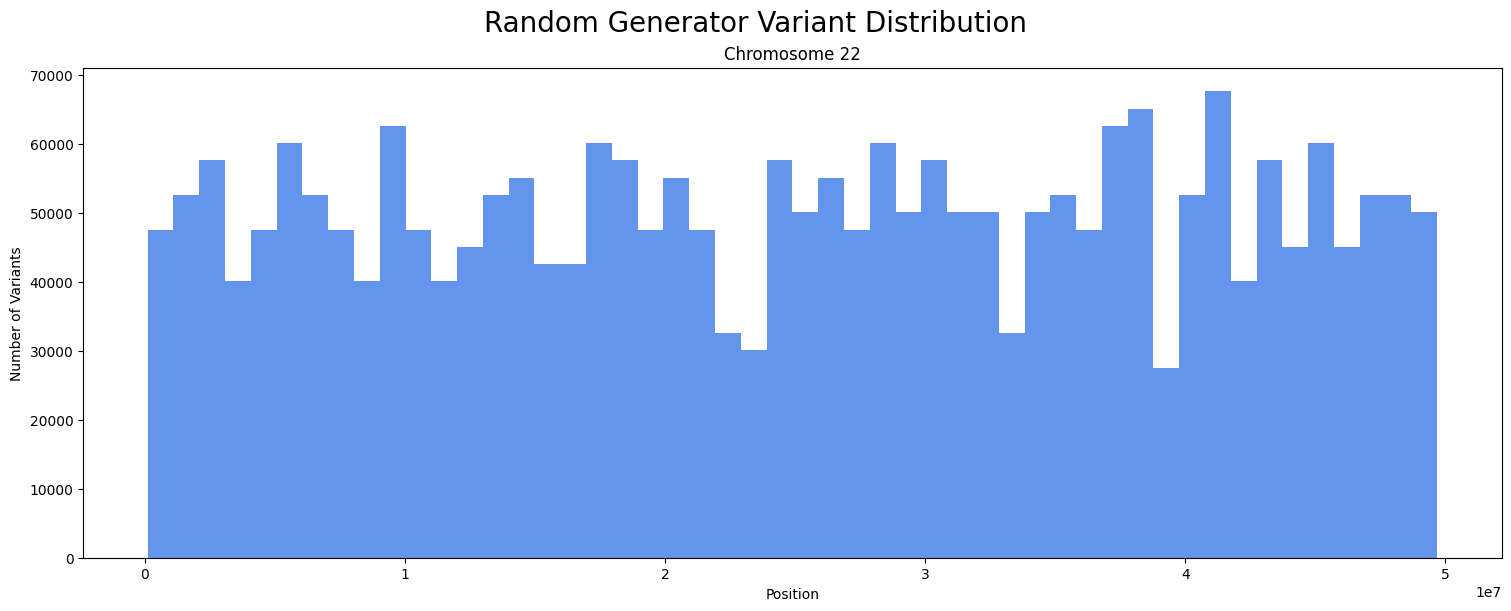

mut_validity: 1.0
----------> Ratio of valid mutations out of all generated ones

mut_quality: 0.8148193035234009
----------> Ratio of locally valid mutations out of all (valid) generated ones

mut_memorization: 0.0
----------> Number of memorized mutations (seen in training)

mut_distribution (see image above):
----------> Positional distribution of generated mutations

mut_novelty: 1.0
----------> Number of novel mutations (unseen in training)

mut_statistics:
- deletions: 0.18447488584474886
- insertions: 0.428310502283105
- substitutions: 0.473972602739726
- biallelic: 0.5744292237442923
- multiallelic: 0.33881278538812787
----------> Distribution of generated mutation types

vcf_quality:
- FILTER: {'PASS': 1.0}
- call_rate: 1.0
- NS: 2504.0
- AC: 1083.7440525020509
- AF: 0.19104220916328368
- AN: 6104.752
- genotypes: {'homozygous_ref': 0.2237699680511182, 'homozygous_alt': 0.2891529552715655, 'heterozygous_ref': 0.4870770766773163}
- aaf: 0.5099147364217252
----------> Statistics

In [42]:
eval_metrics = ['mut_validity', 'mut_quality', 'mut_memorization', 'mut_distribution',
                'mut_novelty', 'mut_statistics', 'vcf_quality']
random_utility_eval = UtilityEval(None, 
                    model_name = 'Random Generator',
                    ref_genomes = TRAIN_DATA, 
                    vcf_file='data/generated/vcfs/random/RandomModel.chr22.2504_samples.vcf',
                    sample_wise = False,)
random_utility_eval.evaluate_model_utility('data/generated/json/random/rand_corpus_chr22_2504ids_1000muts.json',
                                        metrics=eval_metrics, verbose=True)

In [43]:
with open('data/generated/random_utility_eval.json', 'w+') as f:
    json.dump(random_utility_eval.model_utility, f)


In [39]:
with open('data/generated/random_utility_eval.json', 'r') as f:
    random_utility_eval = json.load(f)


Plotting mut_novelty...:   0%|          | 0/9 [00:00<?, ?it/s]     

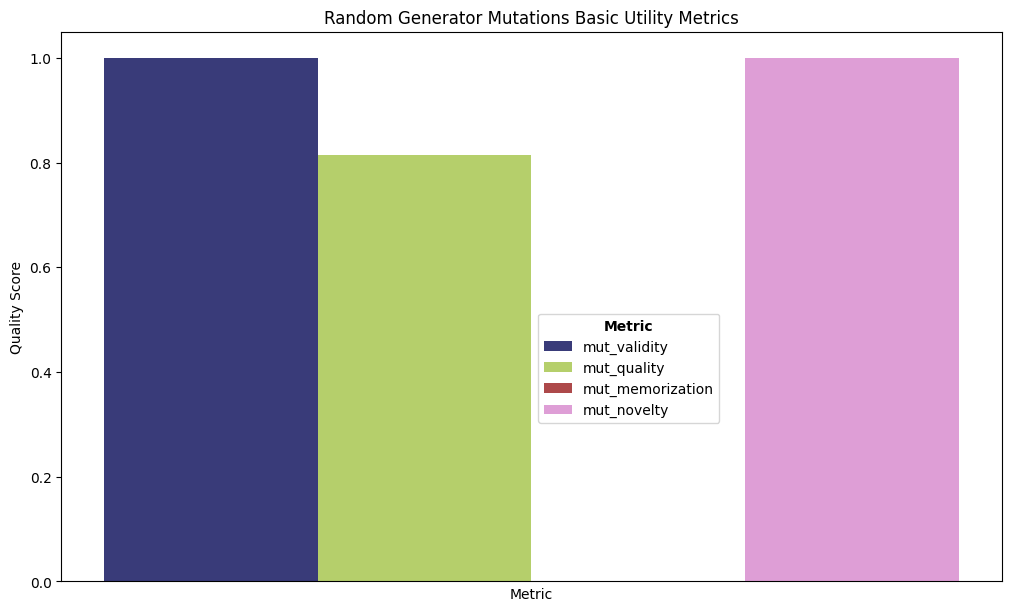

Plotting mut_distribution...:  44%|████▍     | 4/9 [00:00<00:00, 17.88it/s]

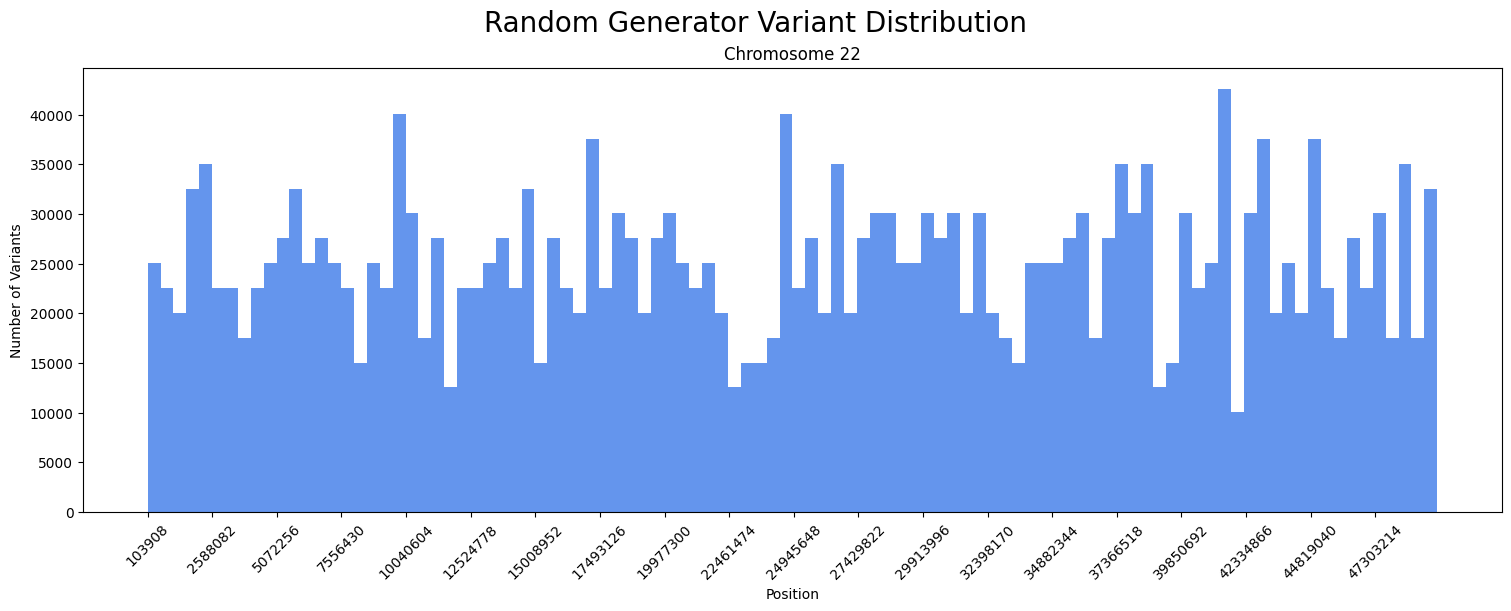

Plotting mut_statistics...:  78%|███████▊  | 7/9 [00:00<00:00,  8.38it/s]  

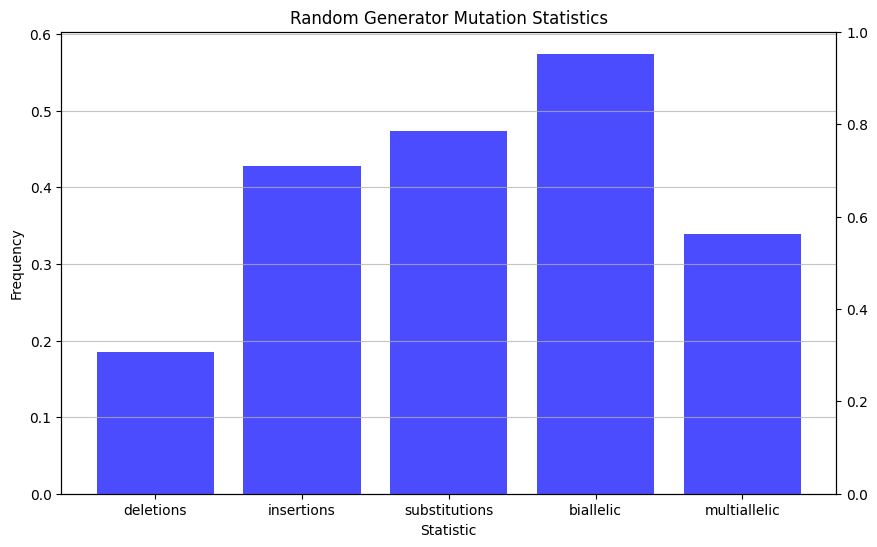

Plotting vcf_quality...:  78%|███████▊  | 7/9 [00:00<00:00,  8.38it/s]   

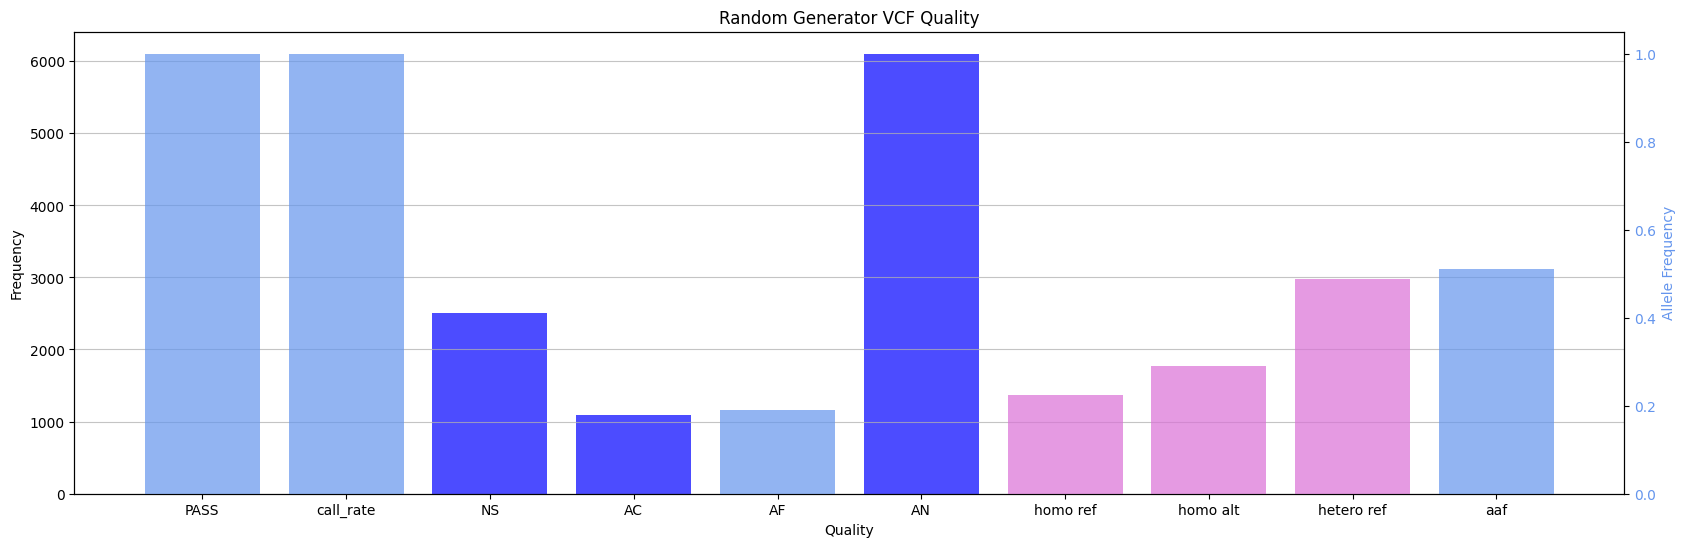

Plotting vcf_quality...: 100%|██████████| 9/9 [00:01<00:00,  8.02it/s]


In [383]:
plot_utility_statistics(random_utility_eval.model_utility, 
                        model_name = 'Random Generator',
                        save_path=f'{SOURCE_DATA_FIGURES}/utility')

___

# 2. minGPT Synthetic Data

In [ ]:
HIGH_RISK_DATA = f'data/sources/json/{data_size}/all_rare_genotypes_{data_size}_chr22.json'
HIGH_RISK_GTS = f'data/sources/json/{data_size}/rare_genotypes_{data_size}_chr22.json'
HIGH_RISK_SAMPLES_LIST = f'data/sources/json/{data_size}/sample_ids_per_dataset.json'

saved_mingpt = f'models/saved/minGPT/minGPT_noDP_{data_size}.pth'
saved_mingpt_dp = f'models/saved/minGPT/DP/minGPT_DP_{data_size}.pth'
saved_gpt2 = f'models/saved/GPT'
saved_gpt2_dp = f'models/saved/GPT/DP'

from models.MinGPT import MinGPT
from models.tokenizers import RegexTokenizer

In [14]:
from importlib import reload
import metrics
reload(metrics)
from metrics import *

import evaluation
reload(evaluation)
from evaluation import UtilityEval

## 2.a Without DP

In [5]:
# load saved minGPT model (no DP)
mingpt = MinGPT.from_pretrained(saved_mingpt)
print(mingpt)

MinGPT(
  (transformer): ModuleDict(
    (wte): Embedding(4104, 384)
    (wpe): Embedding(4676, 384)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=4104, bias=False)
)


In [61]:
eval_metrics = 'all'
mingpt_utility_eval = UtilityEval(model = mingpt, 
                    model_name = 'minGPT (no DP)',
                    ref_genomes = TRAIN_DATA, 
                    # vcf_file = 'data/generated/vcfs/minGPT/mingpt_dp.prova.vcf',
                    sample_wise = False)
mingpt_utility_eval.evaluate_model_utility('data/generated/json/minGPT/mingpt_nodp.json',
                                           metrics=eval_metrics, verbose=False)

Getting valid mutations for analysis...done!


Evaluating minGPT (no DP) utility:  89%|████████▉ | 8/9 [00:10<00:01,  1.20s/it, vcf_quality evaluation...]          

	No valid VCF file path provided. Creating VCF file from passed genotypes...
	Note: sample_wise is set to False. Generating VCF for all samples together.
Generated VCF saved to 'data/generated/vcfs/minGPT/minGPT (no DP).chr1-2-4-7-8-20-22.50_samples.vcf'.


/Users/asiabelfiore/Desktop/Thesis/code/data/data_utils.py:1017: UserWarning: Skipped 8570 bad mutations.
  warnings.warn(f"Skipped {len(bad_muts)} bad mutations.")
Evaluating minGPT (no DP) utility: 100%|██████████| 9/9 [00:15<00:00,  1.69s/it, vcf_quality evaluation...done!]


Plotting mut_repetition...:   0%|          | 0/9 [00:00<?, ?it/s]  

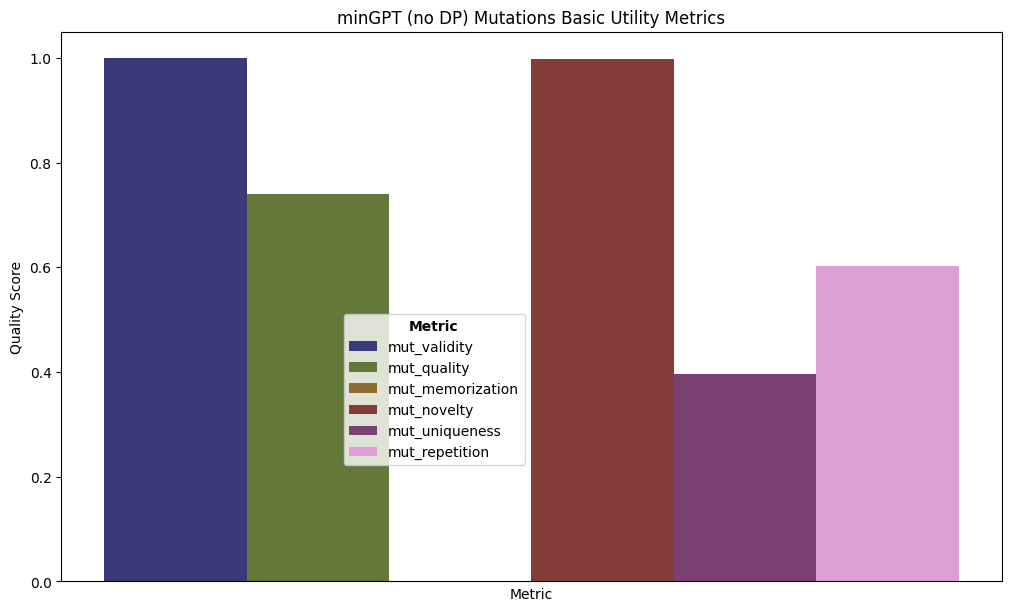

Plotting mut_distribution...:  67%|██████▋   | 6/9 [00:00<00:00, 12.89it/s]

Plotted 37225 mutations for chromosome 22


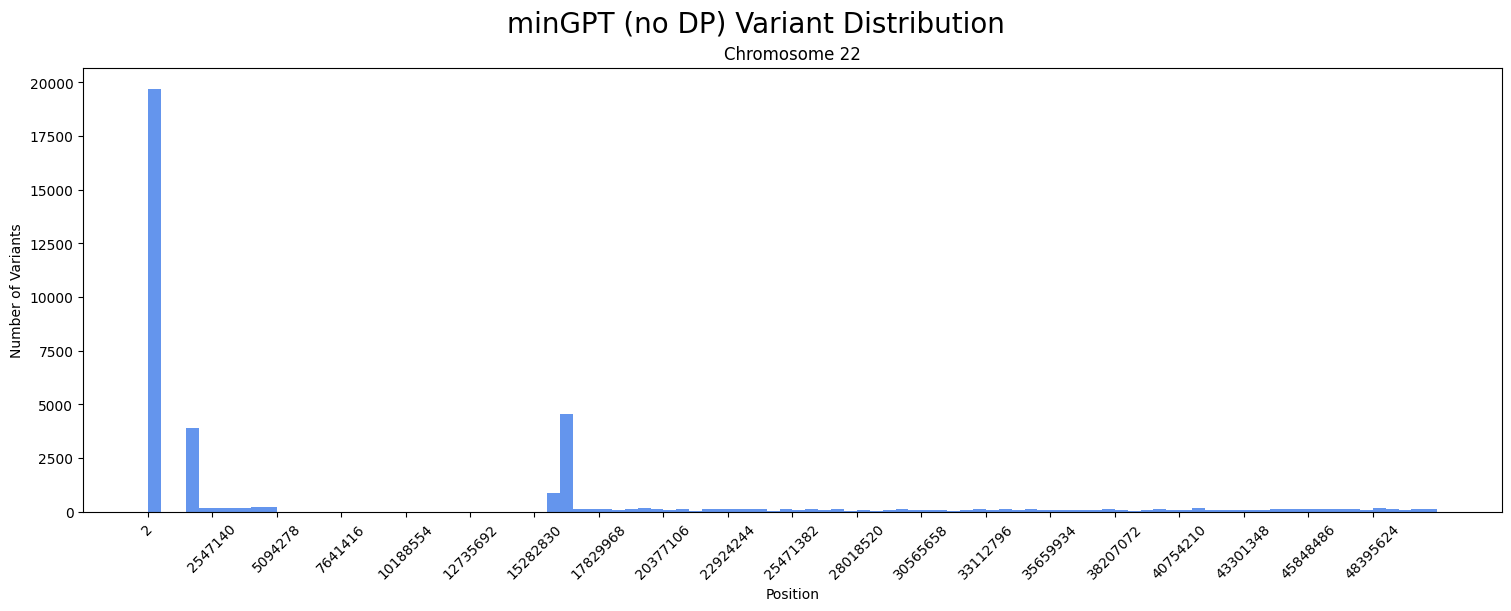

Plotting mut_statistics...:  67%|██████▋   | 6/9 [00:00<00:00, 12.89it/s]  

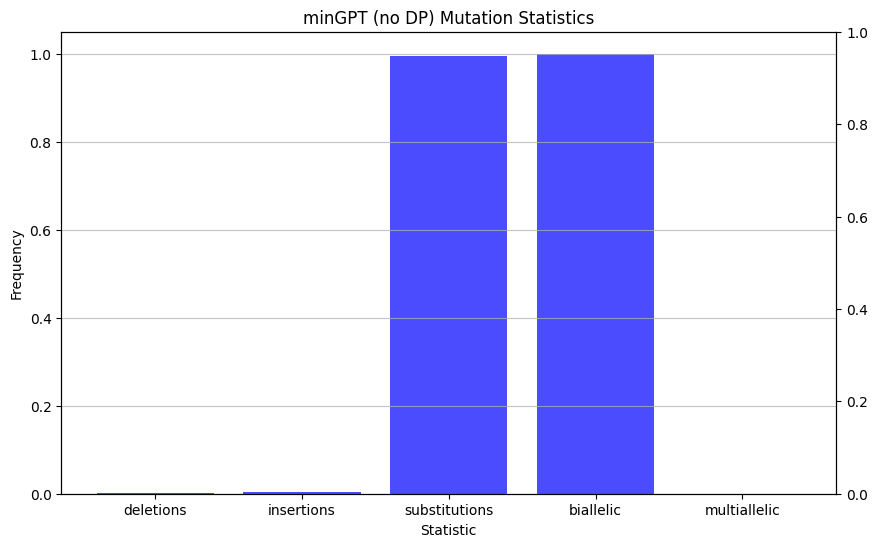

Plotting vcf_quality...:  89%|████████▉ | 8/9 [00:01<00:00,  6.61it/s]   

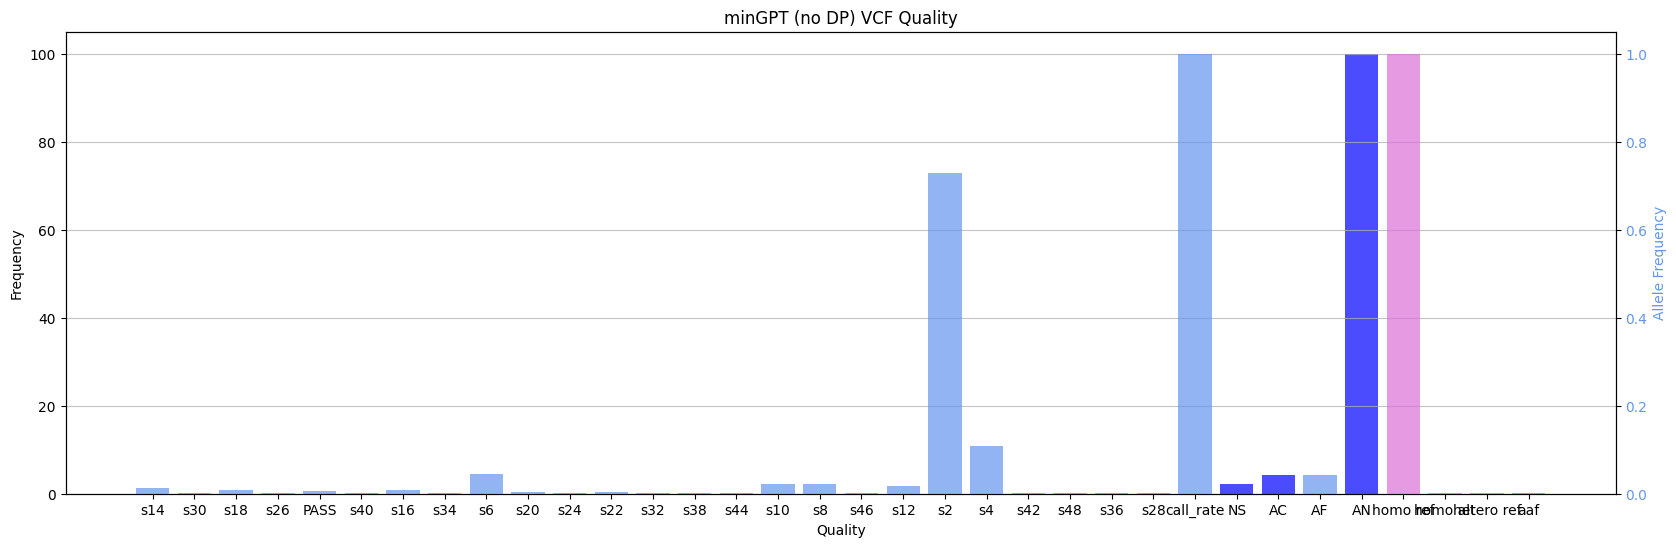

Plotting vcf_quality...: 100%|██████████| 9/9 [00:01<00:00,  6.72it/s]


In [62]:
plot_utility_statistics(mingpt_utility_eval.model_utility, 
                        model_name = 'minGPT (no DP)',
                        save_path=f'{UTILITY_FIGURES}/minGPT')

## 2.b With DP

In [60]:
from importlib import reload
import metrics
reload(metrics)
from metrics import *

import evaluation
reload(evaluation)
from evaluation import UtilityEval

In [ ]:
from models.MinGPT import MinGPT
# load saved minGPT model (with DP)
mingpt_dp = MinGPT.from_pretrained(saved_mingpt_dp)
print(mingpt_dp)

MinGPT(
  (transformer): ModuleDict(
    (wte): Embedding(4104, 384)
    (wpe): Embedding(4676, 384)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=4104, bias=False)
)


In [57]:
eval_metrics = 'all'
mingpt_dp_utility_eval = UtilityEval(model = mingpt_dp, 
                    model_name = 'minGPT (with DP)',
                    ref_genomes = TRAIN_DATA, 
                    # vcf_file = 'data/generated/vcfs/minGPT/mingpt_dp.prova.vcf',
                    sample_wise = False)
mingpt_dp_utility_eval.evaluate_model_utility('data/generated/json/minGPT/mingpt_dp_eps1.json',
                                           metrics=eval_metrics, verbose=False)

Getting valid mutations for analysis...done!


Evaluating minGPT (with DP) utility:  33%|███▎      | 3/9 [00:02<00:04,  1.34it/s, vcf_quality evaluation...]          

Sample 1 has 41 unique genotypes out of 56 total genotypes.
Sample 2 has 34 unique genotypes out of 45 total genotypes.
Sample 3 has 38 unique genotypes out of 54 total genotypes.
Sample 4 has 39 unique genotypes out of 57 total genotypes.
Sample 5 has 35 unique genotypes out of 47 total genotypes.
Sample 6 has 33 unique genotypes out of 44 total genotypes.
Sample 7 has 35 unique genotypes out of 48 total genotypes.
Sample 8 has 34 unique genotypes out of 55 total genotypes.
Sample 9 has 32 unique genotypes out of 47 total genotypes.
Sample 10 has 42 unique genotypes out of 61 total genotypes.
	No valid VCF file path provided. Creating VCF file from passed genotypes...
	Note: sample_wise is set to False. Generating VCF for all samples together.


/Users/asiabelfiore/Desktop/Thesis/code/data/data_utils.py:1017: UserWarning: Skipped 15 bad mutations.
  warnings.warn(f"Skipped {len(bad_muts)} bad mutations.")
Evaluating minGPT (with DP) utility: 100%|██████████| 9/9 [00:03<00:00,  2.70it/s, vcf_quality evaluation...done!]

Generated VCF saved to 'data/generated/vcfs/minGPT/minGPT (with DP).chr22.10_samples.vcf'.


Plotting mut_repetition...:   0%|          | 0/9 [00:00<?, ?it/s]  

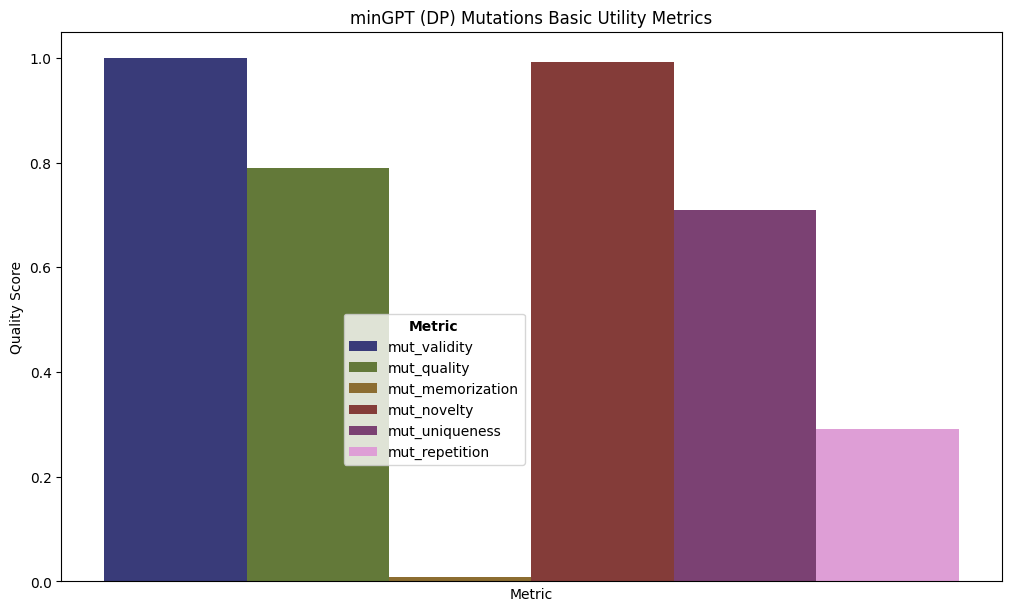

Plotting mut_distribution...:  67%|██████▋   | 6/9 [00:01<00:00,  5.89it/s]

Plotted 499 mutations for chromosome 22


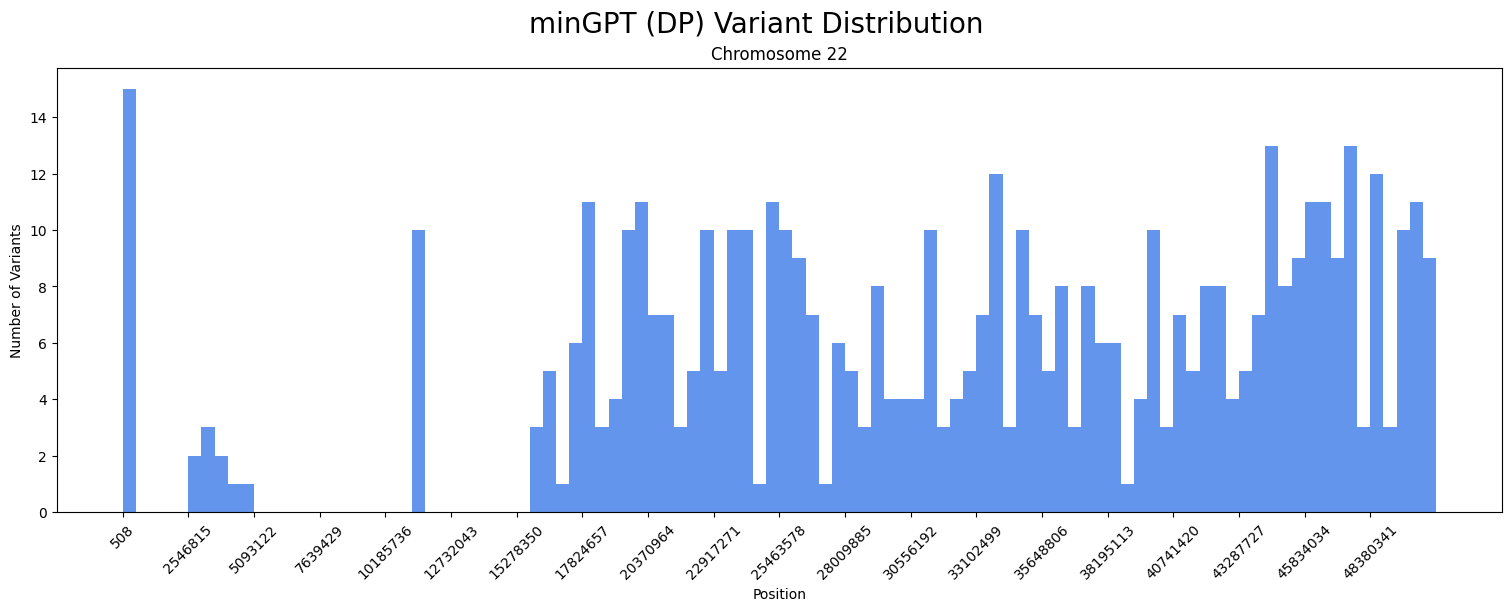

Plotting mut_statistics...:  78%|███████▊  | 7/9 [00:01<00:00,  4.39it/s]  

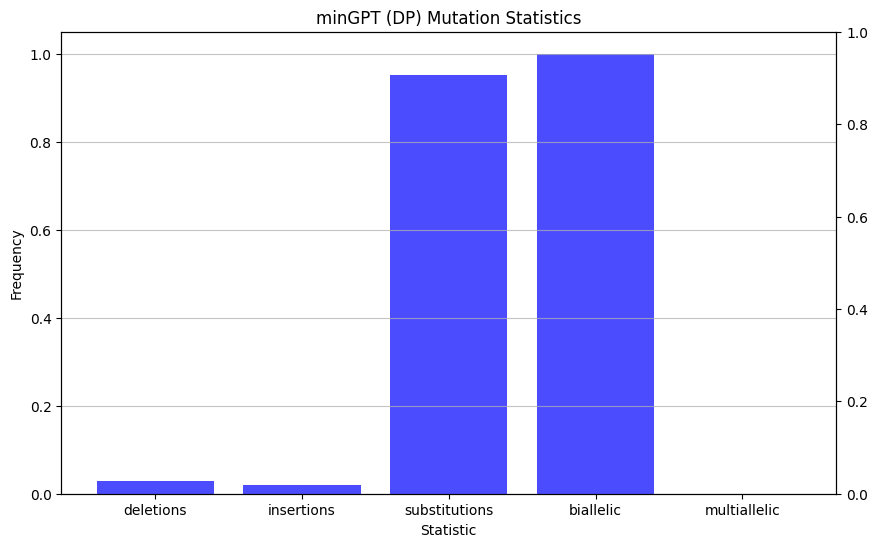

Plotting vcf_quality...:  89%|████████▉ | 8/9 [00:01<00:00,  4.54it/s]   

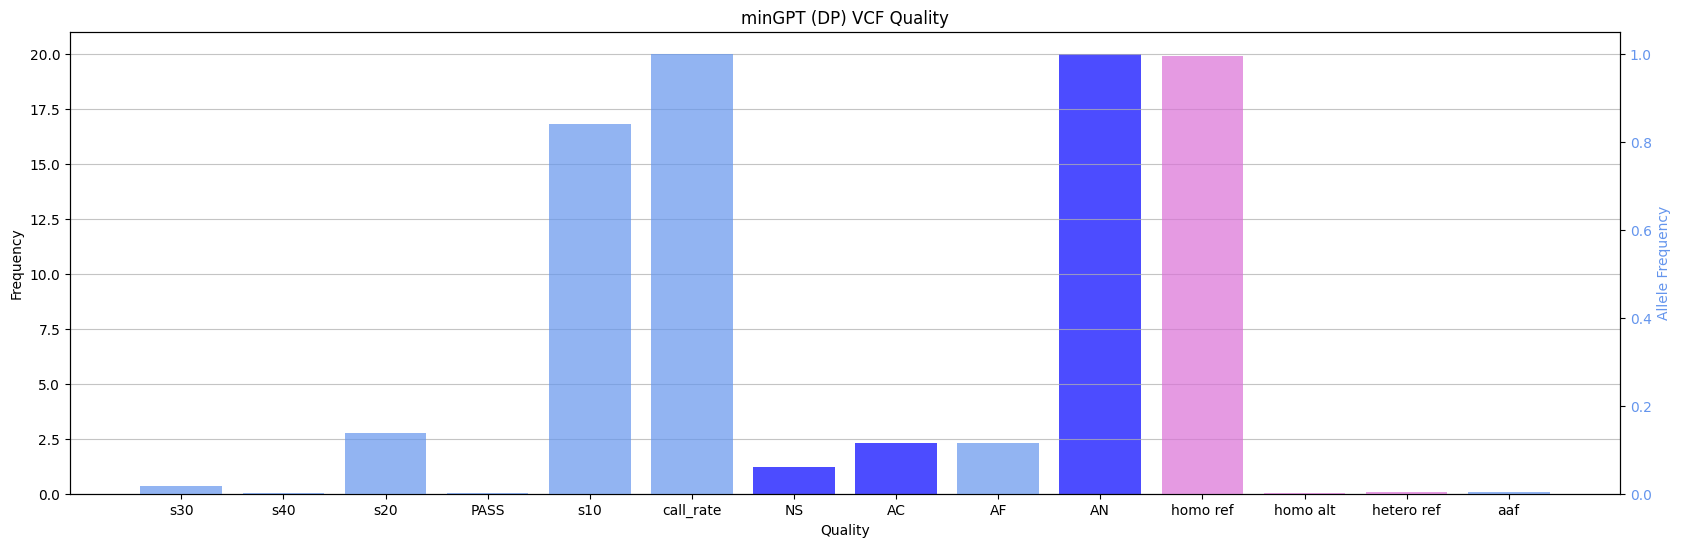

Plotting vcf_quality...: 100%|██████████| 9/9 [00:01<00:00,  4.67it/s]


In [58]:
plot_utility_statistics(mingpt_dp_utility_eval.model_utility, 
                        model_name = 'minGPT (DP)',
                        save_path=f'{UTILITY_FIGURES}/minGPT_DP')

___

# 3. GPT-2 Synthetic Data

## 3.2 Finetuned GPT

In [17]:
from importlib import reload
import metrics
reload(metrics)
from metrics import *

import evaluation
reload(evaluation)
from evaluation import UtilityEval

Getting valid mutations for analysis...done!


Evaluating GPT-2 (no DP) utility:  33%|███▎      | 3/9 [00:02<00:04,  1.48it/s, mut_uniqueness evaluation...]       

Total muts: 95 >> Unique: 6, Memorized: 89 out of 25434 original muts


Evaluating GPT-2 (no DP) utility: 100%|██████████| 9/9 [00:02<00:00,  3.73it/s, vcf_quality evaluation...done!]     


	No valid VCF file path provided. Creating VCF file from passed genotypes...
	Note: sample_wise is set to False. Generating VCF for all samples together.
Generated VCF saved to 'data/generated/vcfs/GPT/GPT-2 (no DP).chr22.50_samples.vcf'.


Plotting mut_repetition...:   0%|          | 0/9 [00:00<?, ?it/s]  

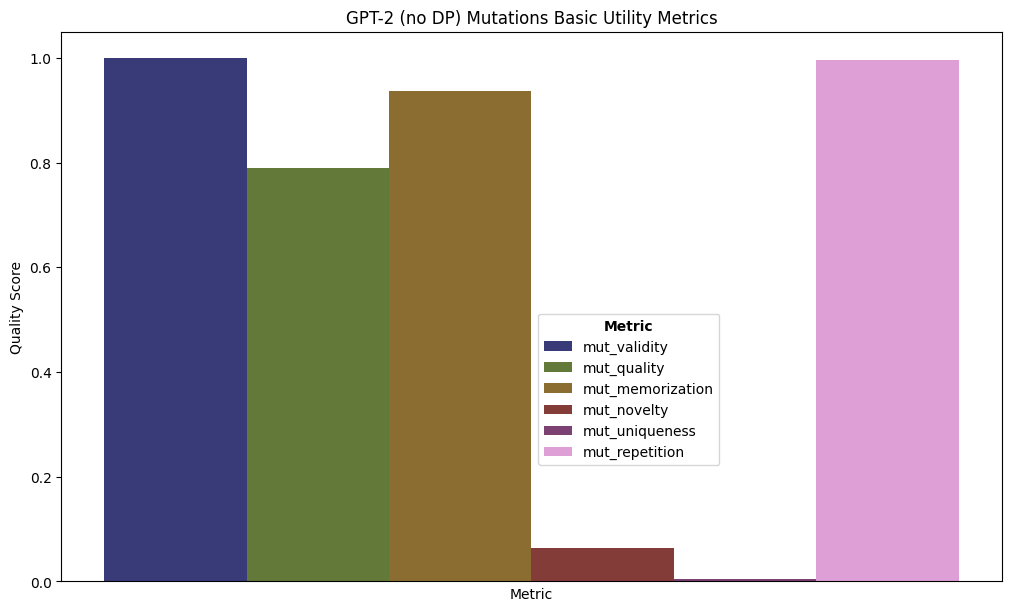

Plotting mut_distribution...:  67%|██████▋   | 6/9 [00:00<00:00, 12.05it/s]

Plotted 3500 mutations for chromosome 22


Plotting mut_distribution...:  67%|██████▋   | 6/9 [00:41<00:00, 12.05it/s]

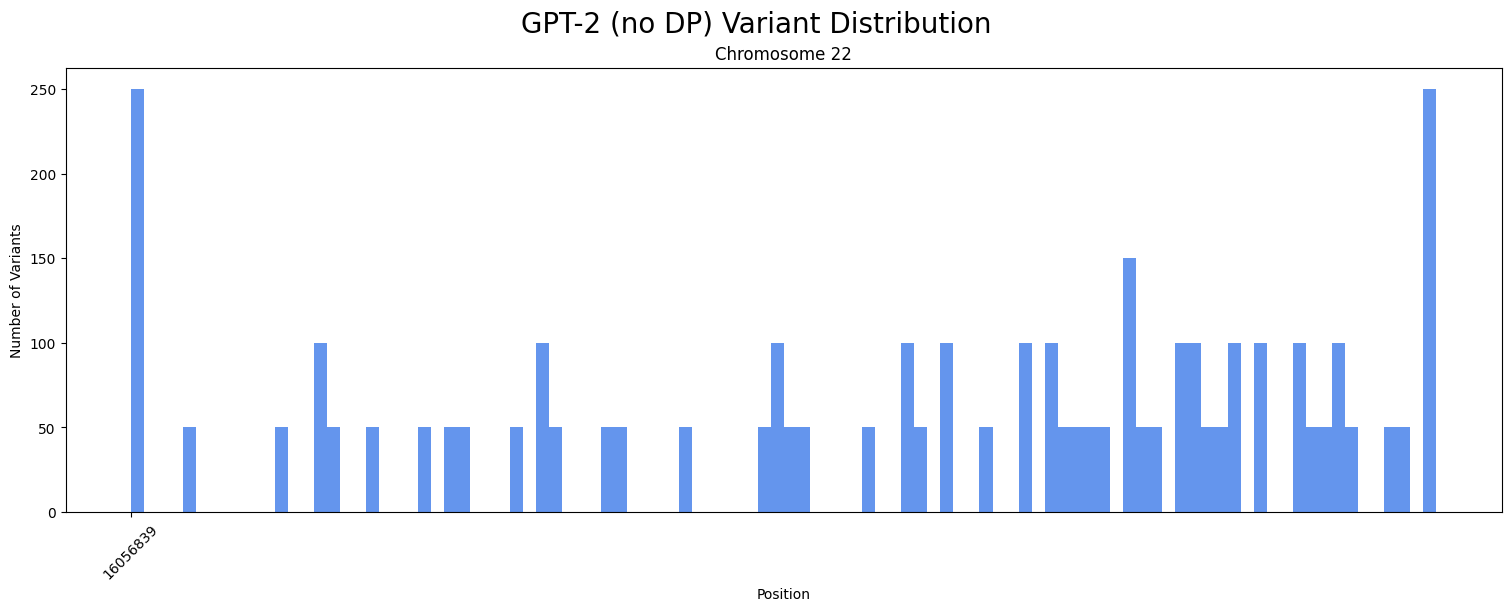

Plotting mut_statistics...:  78%|███████▊  | 7/9 [01:04<00:24, 12.36s/it]  

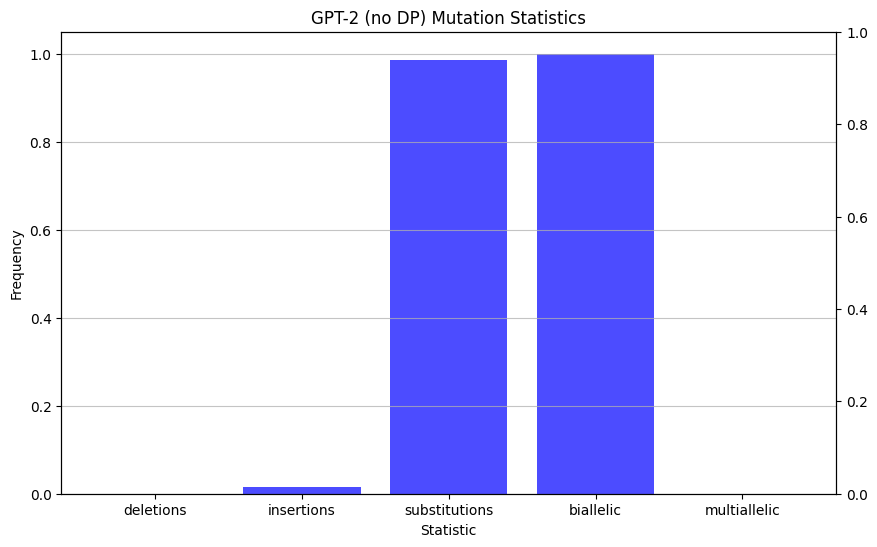

Plotting vcf_quality...:  89%|████████▉ | 8/9 [01:04<00:09,  9.76s/it]   

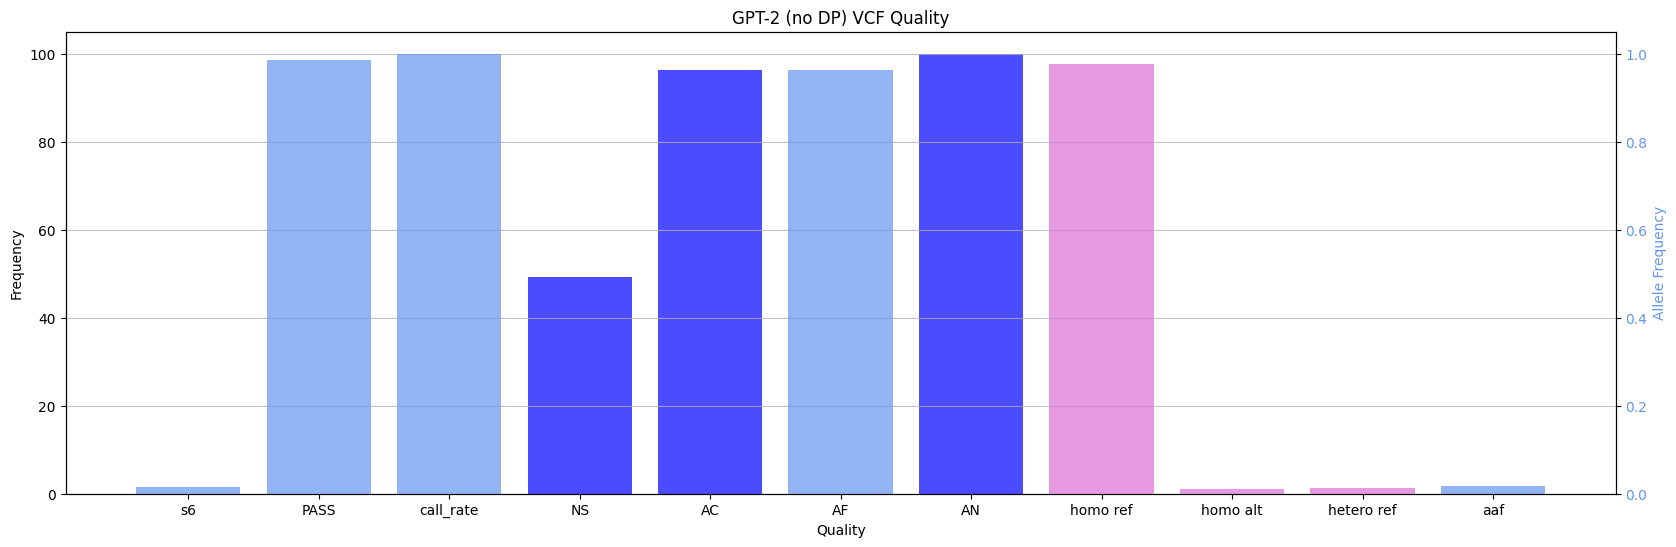

Plotting vcf_quality...: 100%|██████████| 9/9 [01:04<00:00,  7.21s/it]


In [20]:
# eval_metrics = ['mut_validity', 'mut_quality', 'mut_distribution', 'mut_statistics', 'vcf_quality']
eval_metrics = 'all'
gpt2_utility_eval_all = UtilityEval(model = None, 
                    model_name = 'GPT-2 (no DP)',
                    ref_genomes = TRAIN_DATA, 
                    # vcf_file = 'data/generated/vcfs/minGPT/mingpt_dp.prova.vcf',
                    sample_wise = False)
gpt2_utility_eval_all.evaluate_model_utility('data/generated/json/GPT/finetuned_gpt2_50samples.json',
                                           metrics=eval_metrics, verbose=False)
plot_utility_statistics(gpt2_utility_eval_all.model_utility, 
                        model_name = 'GPT-2 (no DP)',
                        save_path=f'{UTILITY_FIGURES}/GPT')